In [98]:
import numpy as np;
import csv
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold 
import math
#import pydot
#import graphviz
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})
import statistics as stcs

import sklearn as sk
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,scale,MinMaxScaler
from scipy.stats import uniform,expon
from sklearn.model_selection import cross_val_score

In [99]:

data = pd.read_csv('NMC_numerical.csv')

def data_split (data, test_ratio):
    np.random.seed(1001)
    df = pd.DataFrame(data)
    total_row = df.shape[0]
    test_row = round(total_row *test_ratio)
    train_row = total_row -test_row
    indices =np.random.permutation(total_row)
    train_indx, test_idx =indices[:train_row], indices[train_row:]
    train,test = df.iloc[train_indx,:], df.iloc[test_idx,:]
    X_test = test.iloc[:,0:20]
    y_test = test.iloc [:,20]
    X_train = train.iloc[:,0:20]
    y_train = train.iloc [:,20]
    return train,X_train,y_train,X_test,y_test
    
train,X_train,y_train,X_test,y_test = data_split(data,0.2)


# 10-fold cross validation
kf = KFold(n_splits=5,random_state =1001,shuffle= True)


In [7]:
rand_para = {'n_estimators':range(101,5001),'max_features':range(1,21),'min_samples_split':range(1,15),
             'max_depth': range(1,15),'min_samples_leaf': range(1,15),'learning_rate':np.logspace(-1,-4)}
reg=GradientBoostingRegressor(random_state = 1001)

n_iteration = 2
Scoring = ['explained_variance','neg_mean_squared_error',"r2"]
random_search = RandomizedSearchCV(reg,param_distributions=rand_para,cv =10,scoring=Scoring,
                                   error_score=0,random_state=1001,return_train_score=True,n_jobs=-1,n_iter=n_iteration,verbose=10,refit=False)


random_search.fit(X_train,y_train)

results_10_fold = pd.DataFrame(random_search.cv_results_)

#y_predict=random_search.predict(X_test)
#math.sqrt(stcs.mean((y_predict-y_test)**2))

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:    4.1s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:    4.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:    4.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    4.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.1s finished
/Users/mike/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [85]:
tuning_para = pd.read_csv('new_selected.csv')

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 0-1: invalid continuation byte

In [88]:
np.random.seed(1001)

overall_results =[]
overall_results_name =['num_tree','max_features','learning_rate','Train_RMSE',"Test_RMSE","R_Square_test"]

for i in tuning_para.iloc[1:100,5]:
    for b in range(5,12):
        for c in tuning_para.iloc[1:100,9]:
            GBM_model_IC =GradientBoostingRegressor(n_estimators=i,max_features=b,learning_rate=c,random_state = 1001)
            for train_index, test_index in kf.split(X_train):
                X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
                y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
                GBM_model_IC.fit(X_training,y_training)
                y_train_predicted = GBM_model_IC.predict(X_validate)
                RMSE_train = math.sqrt(stcs.mean((y_train_predicted-y_validate)**2))
                GBM_model_IC.fit(X_train,y_train)
                y_test_predict = GBM_model_IC.predict(X_test)
                RMSE_test = math.sqrt(stcs.mean((y_predict-y_test)**2))
                total = sum(((results.iloc[:,0]-stcs.mean(results.iloc[:,0]))**2))
                unexplained = sum((results.iloc[:,0]-results.iloc[:,1])**2)
                R_square_test = 1-(unexplained/total)
                overall_results.append([i,b,c,RMSE_train,RMSE_test,R_square_test])

Results_file=pd.DataFrame (overall_results,columns=overall_results_name)
Results_file.to_csv('GBM_EC_results.csv')

# Model Training

In [100]:
np.random.seed(1001)

GBM_model_IC =GradientBoostingRegressor(n_estimators=3295,max_features=5,min_samples_split=4,min_samples_leaf=2,
                                        max_depth=3,learning_rate=0.082864277,random_state = 1001)

train_results =[]
train_results_name =['Experimental','Predicted','RMSE']


for train_index, test_index in kf.split(X_train):
    #print("Train:", train_index, "Validation:", test_index)
    X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
    y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
    GBM_model_IC.fit(X_training,y_training)
    y_train_predicted = GBM_model_IC.predict(X_validate)
    RMSE = math.sqrt(stcs.mean((y_train_predicted-y_validate)**2))
    train_results.append([y_validate,y_train_predicted,RMSE])

In [101]:
Train_results =pd.DataFrame (train_results,columns=train_results_name)

In [102]:
predict_results = pd.DataFrame (Train_results.iloc[:,1])

stcs.mean(Train_results['RMSE'])

18.959087939555857

In [103]:
Experimental =[]
Predicted =[]

for i in range(Train_results.shape[0]):
    Ex=Train_results.iloc[i,0].to_string(index=False)
    Pred = pd.DataFrame(Train_results.iloc[i,1]).to_string(index_names=False,index=False,header=False)
    Ex_num = Ex.split("\n ")
    Pre = Pred.split("\n ")
    a = np.array([float(i) for i in Ex_num])
    b = np.array([float(c) for c in Pre])
    Experimental.extend(a)
    Predicted.extend(b)


In [104]:
Ex= pd.DataFrame(Experimental)

Pred = pd.DataFrame(Predicted)

results =pd.concat([Ex,Pred],axis=1, sort=False)

In [105]:
GBM_model_IC.fit(X_train,y_train)
y_predict = GBM_model_IC.predict(X_test)
#results.to_csv('GBM-IC-TRAIN-EXPERIMENT-PREDICTED.csv')

In [106]:
math.sqrt(stcs.mean((y_predict-y_test)**2))

18.64491188309518

In [107]:
total = sum(((results.iloc[:,0]-stcs.mean(results.iloc[:,0]))**2))
unexplained = sum((results.iloc[:,0]-results.iloc[:,1])**2)

R_square = 1-(unexplained/total)
R_square

0.7656596630670859

In [94]:
Pre_y_test = pd.DataFrame(y_predict,index=None)
Ex_y_test =pd.DataFrame(y_test)
Ex_y_test.reset_index(drop=True, inplace=True)
results_test =pd.concat([Ex_y_test,Pre_y_test],axis=1,join='inner')

In [78]:
results_test.to_csv('GBM-IC-TEST--EXPERIMENT-PREDICTED.csv')

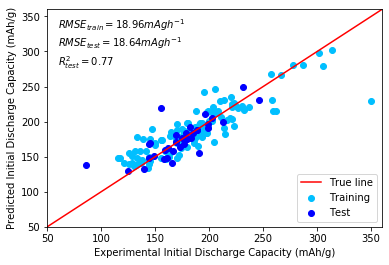

In [113]:
import numpy
import matplotlib.axes as ax
import matplotlib.pyplot as plt

x= y_test
y=y_predict 

plt.axis([50,360,50,360])
plt.scatter(y=results.iloc[:,1],x=results.iloc[:,0],c='deepskyblue',label='Training')
plt.scatter(x,y, c='blue',label='Test')
plt.plot([50,360],[50,360],label ='True line',c='red')
plt.legend(loc='lower right')
#plt.title(label='SVM-EC-Results-Plot')

plt.xlabel(r'Experimental Initial Discharge Capacity (mAh/g)')
plt.ylabel(r'Predicted Initial Discharge Capacity (mAh/g)')
plt.text(60,280,r'$RMSE_{train}=18.96 mAgh^{-1}$'+'\n'+r'$RMSE_{test}=18.64 mAgh^{-1}$' +"\n"+ '$R^2_{test}=0.77$')

#$50^{th}$
plt.savefig('GBM-IC-Predicted-vs-test.png',dpi=600)
plt.show()



Feature: 0, Score: 0.07668
Feature: 1, Score: 0.03874
Feature: 2, Score: 0.06252
Feature: 3, Score: 0.02417
Feature: 4, Score: 0.02662
Feature: 5, Score: 0.08382
Feature: 6, Score: 0.05564
Feature: 7, Score: 0.02176
Feature: 8, Score: 0.09252
Feature: 9, Score: 0.17418
Feature: 10, Score: 0.12944
Feature: 11, Score: 0.00621
Feature: 12, Score: 0.04377
Feature: 13, Score: 0.00983
Feature: 14, Score: 0.04966
Feature: 15, Score: 0.00370
Feature: 16, Score: 0.03205
Feature: 17, Score: 0.03450
Feature: 18, Score: 0.00877
Feature: 19, Score: 0.02540


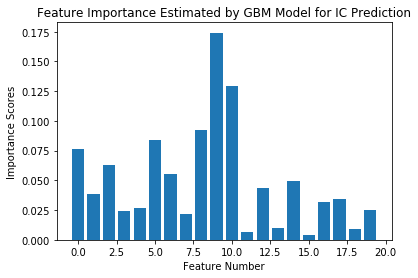

In [86]:

# get importance
importance = GBM_model_IC.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)

plt.title(label='Feature Importance Estimated by GBM Model for IC Prediction')
plt.xlabel(r'Feature Number')
plt.ylabel(r'Importance Scores')

#plt.savefig('GBM-IC-Feature_Importance.png',dpi=600)
plt.show()